In [1]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import pickle
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS


In [3]:
mrblatcomp = mmars.MRBLaT_Functions()

[[-0.02336045  0.        ]
 [-0.01557363  0.        ]
 [-0.00778682  0.        ]]
[[-0.00292006  0.        ]
 [-0.00097335  0.        ]
 [ 0.00097335  0.        ]
 [ 0.00292006  0.        ]]


In [4]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)

[[-0.02336045  0.        ]
 [-0.01557363  0.        ]
 [-0.00778682  0.        ]]
[[-0.00292006  0.        ]
 [-0.00097335  0.        ]
 [ 0.00097335  0.        ]
 [ 0.00292006  0.        ]]


## Setting up the target

In [5]:
target_model_1 = mmars.Target(start_position=np.array([[10.001,10.001]]), start_velocity=1., T_total=100., T_frame=0.1)

target_model_1.generate_trajectory(trajectory_type="sinusoidal")

target_ground_truth = target_model_1.get_trajectory()

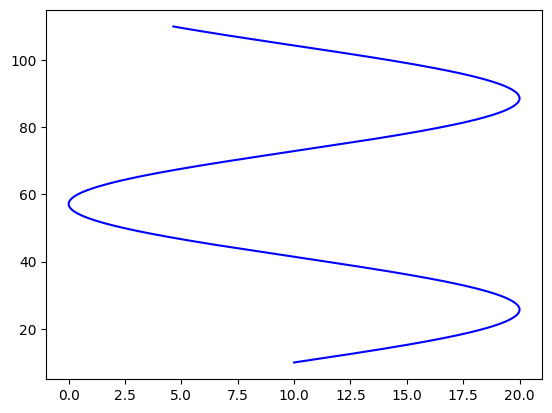

In [6]:
plt.plot(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue")

In [7]:
simulation_data = mmars.Simulation(radar_model_1, target_model_1)

simulation_data.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x00000245CD6F84F0> and <mmars.target.Target object at 0x000002458EBA0DC0>


100%|██████████| 1000/1000 [00:00<00:00, 1072.96it/s]


In [8]:
sim_data = simulation_data.get_data()

In [9]:
frame = 1

print(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

max_range = 100
Ns = 3072


# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier

radar_model_1.generate_S_signal(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

S_N = radar_model_1.get_S_signal.flatten()[:, np.newaxis]/np.sqrt(256)

10.100998333341666 10.100999999999999


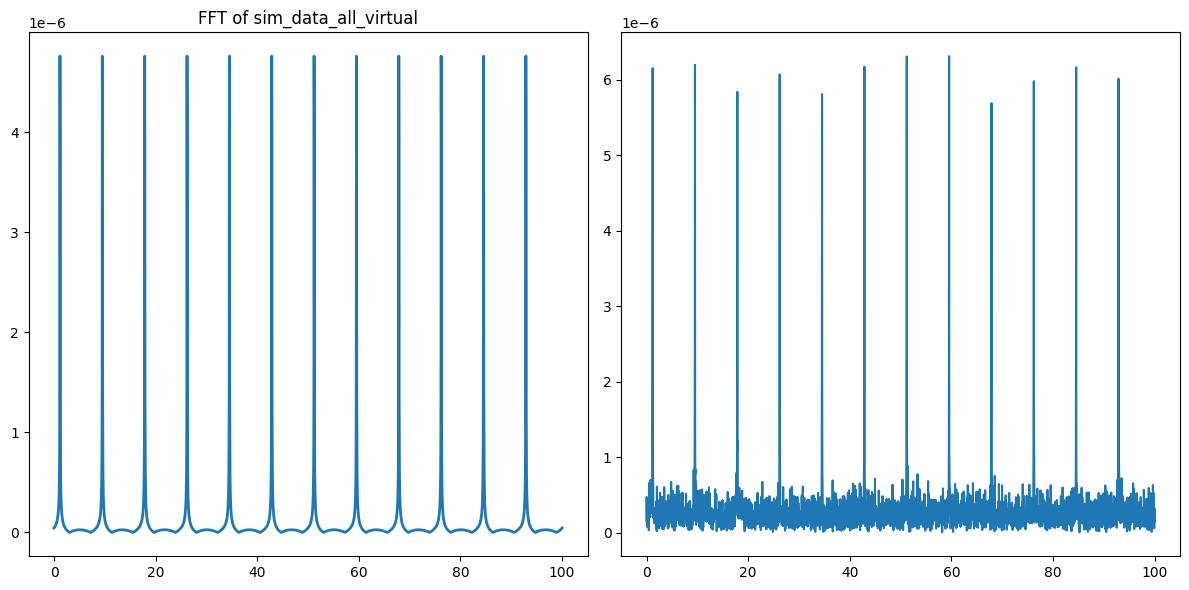

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(S_N), lw=2)
axs[1].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T))

#axs[0].set_xlim([0, 10])
axs[0].set_title('FFT of sim_data_all_virtual')


#axs[1].set_xlim([0, 10])
#axs[1].set_title('Generated S Signal')

plt.tight_layout()
plt.show()

In [11]:
np.abs(mrblatcomp.alpha_hat(S_N, data_fourier.T))

array([[0.86611334]])

In [12]:
mrblatcomp.jacobian_S(np.array([5.5, 5.5]))

array([[3.40693854e-05+0.00000000e+00j, 3.40693854e-05+0.00000000e+00j],
       [3.58808213e-05-4.42073051e-07j, 3.58808213e-05-4.42073051e-07j],
       [3.78701364e-05-9.33306864e-07j, 3.78701364e-05-9.33306864e-07j],
       ...,
       [2.36792703e-05+1.98515934e-05j, 2.27065519e-05+2.09572447e-05j],
       [2.48966549e-05+2.07589736e-05j, 2.42976531e-05+2.14569910e-05j],
       [2.62261044e-05+2.17471566e-05j, 2.60257827e-05+2.19864961e-05j]])

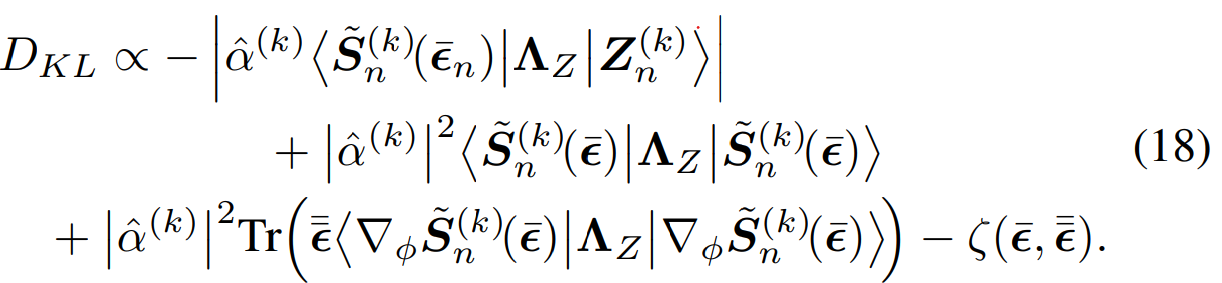

In [13]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (radar_model_1.get_standardDeviation)**(-2)
Lambda_z = csr_matrix(Lambda_z)

In [14]:
frame = 1

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual
data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])
data_fourier_energy = data_fourier.conj().T @ data_fourier
data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

In [15]:
last_frame_x = target_model_1.get_trajectory()[0][frame-1]
last_frame_y = target_model_1.get_trajectory()[1][frame-1]
print(last_frame_x, last_frame_y)

param = (last_frame_x, last_frame_y, 0.5, 0.5)
bound = [(-100,100), (0.1,100), (0.01, 10), (0.01, 10)]

result = minimize(mmars.mrblatFunctions.D_KL, param, bounds = bound,  args=(data_fourier, last_frame_x, last_frame_y, Lambda_z, radar_model_1, mrblatcomp, (1,1,1,1), True), method='nelder-mead')

10.001 10.001
[[1218.13042266]] [[1322.91795318]] [[3678945.88862903]] 2.1447298858494
[[2561.44270642]] [[1199.96958883]] [[3287419.20169294]] 2.1447298858494
[[2046.90674955]] [[1199.96958883]] [[3302238.04232462]] 2.1447298858494
[[1218.13042266]] [[1322.91795318]] [[3770919.53584476]] 2.169124967934116
[[1218.13042266]] [[1322.91795318]] [[3770919.53584476]] 2.169124967934116
[[2480.72381563]] [[1201.3849613]] [[3257353.21363597]] 2.1314295449508105
[[965.07992712]] [[1110.51157203]] [[3309576.36705505]] 2.110456614581845
[[965.07992711]] [[1110.51157203]] [[3309576.36705505]] 2.112960375447156
[[-592.79405468]] [[1060.92757216]] [[2891971.23816672]] 2.1224844729325034
[[366.73381477]] [[954.06215664]] [[2576597.44616385]] 2.1110732856817025
[[353.23578438]] [[1093.7941523]] [[3352484.60268346]] 2.152623785929386
[[805.55463398]] [[1104.50398552]] [[3334958.88351031]] 2.1232004090634407
[[-571.34628964]] [[1070.41176928]] [[2880691.52244373]] 2.121326860928226
[[-589.02843411]] [[1

In [16]:
print(f"{result.x}\n{target_ground_truth[0][frame], target_ground_truth[1][frame]}")

[1.13545067e+01 9.67291751e+00 1.00000000e-02 1.00000000e-02]
(np.float64(10.100998333341666), np.float64(10.100999999999999))


In [17]:
bounds = [(-100,100), (0.1,100), (0, 10), (0, 10)]

result = differential_evolution(D_KL, bounds, args=(data_fourier, last_frame_x, last_frame_y))

NameError: name 'D_KL' is not defined

In [ ]:
np.sqrt(result.x[2]), np.sqrt(result.x[3])

(np.float64(1.7149221890055524), np.float64(1.128479085184062))

In [ ]:
target_ground_truth[0][0]

np.float64(10.001)

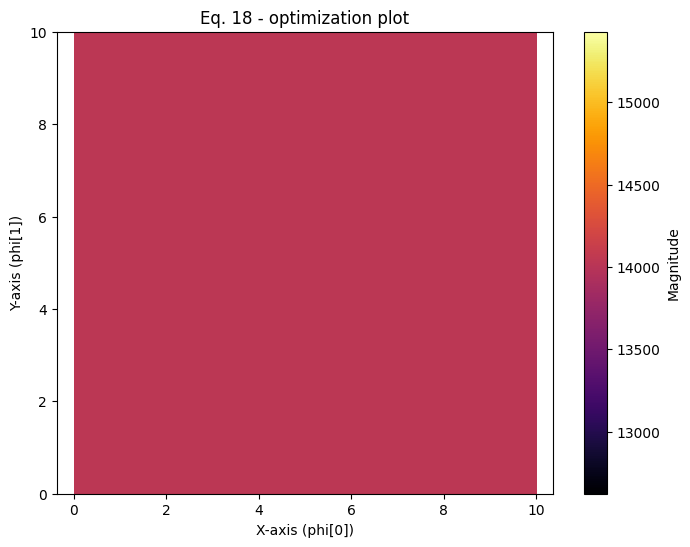

In [ ]:
D_KL_search_space = np.linspace(0.01, 10, 100)

# Use parallel processing to speed up the nested loop
results = []
for i in D_KL_search_space:
    for j in D_KL_search_space:
        result = D_KL(
            np.array([5.5, 5.5, i, j]),
            data_fourier,
            target_model_1.get_trajectory()[0][frame-1],
            target_model_1.get_trajectory()[0][frame-1]
        )
        results.append(result)

# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

gridsize = 100

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(results).reshape(gridsize, gridsize)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[0, 10, 0, 10], cmap='inferno', aspect='auto')
#min_index = np.argmin(heatmap)
#min_index_2d = np.unravel_index(min_index, heatmap.shape)
#plt.scatter(min_index_2d[1]/gridsize, min_index_2d[0]/gridsize, marker='x', color='red', s=100)
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [ ]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)

print(f"Minimum value at index: {min_index_2d}")

np.min(heatmap)

Minimum value at index: (np.int64(0), np.int64(0))


np.float64(14025.543139649468)

In [ ]:
gridsize = 100

# Define the range for phi[0] and phi[1]
x_values = np.linspace(0.0001, 50.0001, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0.0001, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [4.941e-01],  [4.686e-01]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [ ]:
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(D_KL(phis[n][:4].flatten(), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1]))

(100, 50)


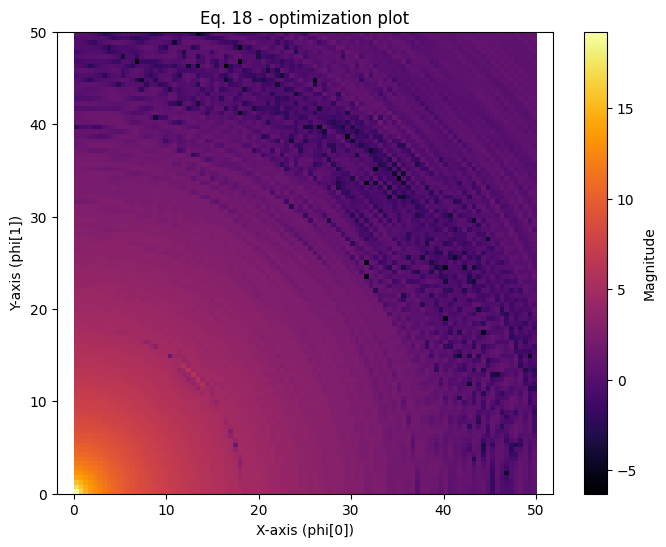

In [ ]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)
print(heatmap[:100,:50].shape)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.log(np.abs(heatmap[1:,1:])), origin='lower', extent=[0, 50, 0, 50], cmap='inferno', aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [ ]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(heatmap)

Minimum value at index: (np.int64(26), np.int64(26))
x: 13.131413131313131, y: 13.131413131313131


np.float64(-454.9370967652401)

In [ ]:
delta_t = 0.1

T = np.array([[1, 0, delta_t, 0],
            [0, 1, 0, delta_t],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

G = np.diagflat([(delta_t**2)/2,(delta_t**2)/2,delta_t,delta_t])

G_inv = np.linalg.inv(G)

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

In [ ]:
def broadcast_parameters(n, phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_):
    """
    Each radar computes eps_bar and eps_barbar and broadcasts them.
    """
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n,:,:,0,:].flatten()[:, np.newaxis]
    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

    #S_signals = Parallel(n_jobs=-1)(delayed(D_KL)(phis[n][:2].flatten(), data_fourier) for n in range(len(phis)))

    # Find the index of the minimum value in S_signals
    #min_index = np.argmin(S_signals)

    # Convert the flat index to 2D index
    #min_index_2d = np.unravel_index(min_index, (gridsize, gridsize))

    # Get the corresponding x and y values
    #epsbar_x = x_values[min_index_2d[1]]
    #epsbar_y = y_values[min_index_2d[0]]

    result = minimize(D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_), method="L-BFGS-B")

    #result = differential_evolution(D_KL, bounds, args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_))

    #result1 = differential_evolution(D_KL3_entropy, bounds1, args=(phi_bar_last_x_, phi_bar_last_y_, result.x[0], result.x[1]))

    return np.array([[result.x[0]], [result.x[1]], [result.x[2]], [result.x[3]]])


def message_passing(N_iter = 100, N = 10):
    eps_bar_list = []
    eps_barbar_list = []

    phi_bar_list = [np.array([[5], [5], [0], [0]])]
    phi_eq18 = [np.array([[5], [5], [0], [0]])]
    phi_barbar_list = [np.array([[0.1,0,0,0], [0,0.1,0,0], [0,0,0,0], [0,0,0,0]])]

    Lambda_a = np.diagflat([0.1,0.1,0.1,0.1])


    for n in tqdm(range(N)):
        D_KL = broadcast_parameters(n+1, phi_bar_list[n][0, 0], phi_bar_list[n][1, 0], phi_barbar_list[n][0, 0], phi_barbar_list[n][1, 1])
        eps_bar = D_KL[:2]
        eps_bar = np.vstack((eps_bar, np.array([[0.000], [0.000]])))
        eps_bar_list.append(eps_bar)
        phi_eq18.append(eps_bar_list[n])
        eps_barbar_list.append(np.array([[D_KL[2][0],0,0,0], [0,D_KL[3][0],0,0], [0,0,1e20,0], [0,0,0,1e20]]))

        beta = np.zeros((4,4))
        alpha = n+1

        for _ in range(N_iter):
            for i in range(len(phi_bar_list)):
                if i-n == 0:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i]
                else:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G + T.T@G_inv.T@Lambda_a@G_inv@T
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i] + (T.T@G_inv.T@Lambda_a@G_inv@T)@np.linalg.inv(T)@phi_bar_list[i+1]
                    
                if n > 0:
                    beta += np.linalg.norm(np.linalg.inv(G)@(phi_bar-T@phi_bar_list[i]))**2 + G_inv@(np.linalg.inv(phi_bar_bar_inv)+T@phi_barbar_list[i]@T.T)@G_inv.T
        
        if n > 0:
            Lambda_a = np.linalg.inv(beta/alpha)
        
        phi_bar_list.append(phi_bar)
        phi_barbar_list.append(np.linalg.inv(phi_bar_bar_inv))

        
    
    return phi_bar_list, phi_barbar_list, phi_eq18

In [ ]:
mrblat_data, mrblat_data_phibarbar, eq18 = message_passing()

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


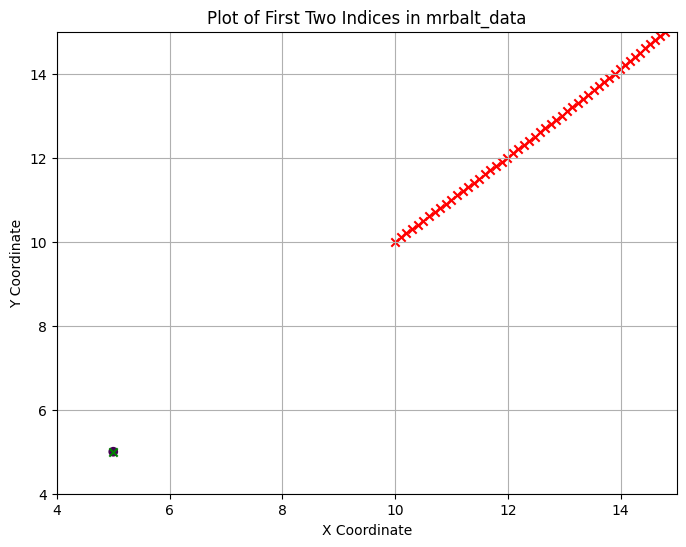

In [ ]:
# Extract the first two indices from mrbalt_data
x_coords = [data[0, 0] for data in mrblat_data]
y_coords = [data[1, 0] for data in mrblat_data]

x_coords1 = [data[0, 0] for data in eq18]
y_coords1 = [data[1, 0] for data in eq18]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords,c=np.linspace(0, 1, len(x_coords)), cmap='viridis', marker='o')
plt.scatter(x_coords1, y_coords1, c='green', marker='x')
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x')
plt.xlim([4, 15])
plt.ylim([4, 15])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of First Two Indices in mrbalt_data')
plt.grid(True)
plt.show()

In [ ]:
mrblat_data, mrblat_data_phibarbar

([array([[5],
         [5],
         [0],
         [0]]),
  array([[0.5159066 ],
         [0.47098687],
         [0.        ],
         [0.        ]]),
  array([[0.44078891],
         [0.12280644],
         [0.        ],
         [0.        ]]),
  array([[ 4.18609215e+03],
         [-5.20547849e+03],
         [-5.34732763e-10],
         [-1.52649826e-10]]),
  array([[ 4.18550030e+03],
         [-5.20474102e+03],
         [-6.86771019e-10],
         [-6.79159756e-10]]),
  array([[ 4.18550025e+03],
         [-5.20473945e+03],
         [-2.56641263e-13],
         [-2.55099964e-13]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-1.61897719e-15],
         [ 1.48487879e-15]]),
  array([[ 4.18550350e+03],
         [-5.20474218e+03],
         [-3.82648614e-17],
         [ 3.82667758e-17]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-2.78228025e-20],
         [ 2.80030114e-20]]),
  array([[ 4.18550350e+03],
         [-5.20474219e+03],
         [-9.1

In [ ]:
results = np.zeros((71, 4))

results[0] = np.array(([5, 5, 0.5, 0.5]))  # Initialize results as a list of lists

bounds = [(5,50), (5,50), (0.01, 10), (0.01, 10)]

for n in tqdm(range(70)):
    print(n)

    sim_data_all_virtual = sim_data[n+1,:,:,0,:]
    sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    #bounds = [(results[n-1, 0]-10,results[n-1, 0]+10), (results[n-1, 0]-10,results[n-1, 0]+10)]
    #print(bounds)
    result = minimize(D_KL, (results[n][0], results[n][1], 0.5, 0.5), args=(data_fourier, results[n][0], results[n][1]), method="L-BFGS-B")
    #result = differential_evolution(D_KL, [(5,50), (5,50), (0.01, 10), (0.01, 10)], args=(data_fourier, results[n][0], results[n][1]))

    results[n+1] = result.x.tolist()  # Insert the result at the correct index

  0%|          | 0/70 [00:00<?, ?it/s]

0


  1%|▏         | 1/70 [00:00<00:56,  1.22it/s]

1


  3%|▎         | 2/70 [00:01<00:38,  1.75it/s]C:\Users\malth\AppData\Local\Temp\ipykernel_33180\3163116464.py:30: RuntimeWarning: invalid value encountered in log
  entropy = k/2 * np.log(2*np.pi*np.e) + 1/2*np.log(eps_barbar_0 * eps_barbar_1)


2


  4%|▍         | 3/70 [00:01<00:32,  2.05it/s]

3


  6%|▌         | 4/70 [00:02<00:45,  1.45it/s]

4


  6%|▌         | 4/70 [00:03<00:53,  1.22it/s]


KeyboardInterrupt: 

In [ ]:
# Extract the first two indices from results
x_results = [result[0] for result in results]
y_results = [result[1] for result in results]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_results, y_results, c=np.linspace(0, 1, len(x_results)), cmap='viridis', marker='o', label='Results')
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x', label='Ground Truth')
#plt.scatter(eq18[0][0], eq18[1][0], c='green', marker='x', label='Eq. 18')
plt.xlim([4, 20])
plt.ylim([4, 50])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Results and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'results' is not defined